# LSTM network for Sentinel-2 clouds removing

The model is based on convolutional LSTM layers, it takes in input 3 images and returns a new image that have to be as similar as possible to the fourth image. Each image is associated to an acqusition, in this case the dataset created ad hoc is composed of time series of four images, with a one month interval, for both Sentinel-1 and Sentinel-2.

## Packages requirements
### Install rasterio on colab machine

In [ ]:
!pip install rasterio
!pip install scikit-image

### Mount drive to get access to the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Main dependancies

In [ ]:
from numpy.random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np

## Functions to read the dataset 

In [ ]:
def get_images_path(path, satellite):
    '''
        It returns a list of path. 
        Satellite must be 'sen1' or 'sen2'.
        Path must be the master folder with 'sen1' and 'sen2' folder inside
    '''
    path = os.path.join(path, satellite)
    
    images_path = []
    
    zones = os.listdir(path)
    for zone in zones:
        zone_path = os.path.join(path, zone)
        
        images = os.listdir(zone_path)
        
        for image in images:
            image_path = os.path.join(zone_path, image)
            images_path.append(image_path)
            
    images_path.sort()
    return images_path, zones
    
def get_s2_image(image_path, normalization='minmax'):
    '''
        It returns an RGB image using a path.
        Image path must be the full path of an RGB image (tif format)
    '''
    
    # rasterio function to read bands of a tif file
    dataset = rasterio.open(image_path)
    r = dataset.read(1)
    g = dataset.read(2)
    b = dataset.read(3)
    dataset.close()
    
    # RGB composite
    rgb = np.zeros((r.shape[0],r.shape[1], 3))
    rgb[...,0] = r
    rgb[...,1] = g
    rgb[...,2] = b
    
    if normalization == 'minmax':
      # Normalization
      rgb = (rgb - rgb.min())/(rgb.max() - rgb.min())
    elif normalization =='std':
      # Standardization
      rgb = (rgb - rgb.mean())/(rgb.std())
    
    return rgb.astype(float)

def split_S2_images(s2_paths):
    '''
        It splits a list of Sentinel-2 path and returs two new lists: rgb images and cloud masks.
        The path must contains 'RGB' or 'CM'.
    '''
    
    cloud_mask = []
    rgb = []
    
    for p in s2_paths:
        if "RGB" in p:
            rgb.append(p)
        elif "CM" in p:
            cloud_mask.append(p)
    
    return rgb, cloud_mask

def get_s1_image(image_path, normalization='minmax'):
    '''
        It returns an grayscale image (VV Sentinel-1) using a path.
        Image path must be the full path of an grayscale (VV) image (tif format)
    '''
    
    # rasterio function to read bands of a tif file
    dataset = rasterio.open(image_path)
    vv = dataset.read(1)
    dataset.close()
    
    if normalization == 'minmax':
      # Normalization
      vv = (vv - vv.min())/(vv.max() - vv.min())
    elif normalization == 'std':
      vv = (vv - vv.mean())/(vv.std())
    
    return vv.astype(float)

def date_sort(e):
    
    ''' 
        This function is used to sort the paths by the months order. 
    '''
    
    s = 0
    if 'Jan' in e:
        s = 0
    elif 'Feb' in e:
        s = 1
    elif 'Mar' in e:
        s = 2
    elif 'Apr' in e:
        s = 3
    elif 'May' in e:
        s = 4
    elif 'Jun' in e:
        s = 5
    elif 'Jul' in e:
        s = 6
    elif 'Aug' in e:
        s = 7
    elif 'Sep' in e:
        s = 8
    elif 'Oct' in e:
        s = 9
    elif 'Nov' in e:
        s = 10
    elif 'Dec' in e:
        s = 11
    
    return s

def patch_sort(e):
    
    ''' 
        This function is used to sort the paths by the patch order. 
    '''
    
    s = 0
    if 'patch_0.tif' in e:
        s = 0
    elif 'patch_1.tif' in e:
        s = 1
    elif 'patch_2.tif' in e:
        s = 2
    elif 'patch_3.tif' in e:
        s = 3
    elif 'patch_4.tif' in e:
        s = 4
    elif 'patch_5.tif' in e:
        s = 5
    elif 'patch_6.tif' in e:
        s = 6
    elif 'patch_7.tif' in e:
        s = 7
    elif 'patch_8.tif' in e:
        s = 8
    elif 'patch_9.tif' in e:
        s = 9
    elif 'patch_10.tif' in e:
        s = 10
    elif 'patch_11.tif' in e:
        s = 11
    elif 'patch_12.tif' in e:
        s = 12
    elif 'patch_13.tif' in e:
        s = 13
    elif 'patch_14.tif' in e:
        s = 14
    elif 'patch_15.tif' in e:
        s = 15
    
    return s

def get_time_series(images):
    images.sort(key=patch_sort)
    series = []
    counter = 0
    for i in range(int(len(images)/4)):

        se = []

        for j in range(4):
            se.append(images[counter])
            se.sort(key=date_sort)
            counter = counter + 1

        for j in range(4):
            series.append(se[j])
            
    return series

def image_generator(s2_paths, batch_size = 16, augmentation = False, print_info = False, normalization='minmax'):
    
    '''
        Image generator keras like. It provides also data augmentation.
    '''
    
    if augmentation:
    
        datagen = ImageDataGenerator(
            rotation_range=45,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='wrap' # or 'wrap'
        )
    
    batch_s2_input  = np.zeros((batch_size,3,256,256, 3))
    #batch_s1_input  = np.zeros((batch_size,4,256,256, 1))
    batch_output  = np.zeros((batch_size,1,256,256, 3))
    
    while True:   
           
      for i in range(0, int(batch_size)): 
          
        batch_index = randint(0, high=int(len(s2_paths)/4))*4
        
        if print_info:
          print(batch_index)
        
        if augmentation:
          seed = random.seed()
          transformation = datagen.get_random_transform((256,256), seed=seed)
        
        for j in range(4):
            
          s2 = get_s2_image(s2_paths[batch_index+j], normalization)
          #s1 = get_s1_image(s1_paths[batch_index+j], normalization)
          
          if augmentation:
              s2 = datagen.apply_transform(s2, transformation)
              #s1 = datagen.apply_transform(s1, transformation)

          # Some images may be smaller than 256x256 pixels, 
          # so the following code forces copying

          if j == 3:
            batch_output[i,0,:s2.shape[0],:s2.shape[1],...] = s2
          else:
            batch_s2_input[i,j,:s2.shape[0],:s2.shape[1],...] = s2
          
          #batch_s1_input[i,j,:s1.shape[0],:s1.shape[1],0] = s1
      
      yield batch_s2_input, batch_output

### Load the images paths of dataset

In [ ]:
dataset_path = '/content/drive/My Drive/timeseries_dataset'
#dataset_path = '/content/drive/My Drive/timeseries_dataset/timeseries_dataset_p2/val_2'
s2_paths, s2_zones = get_images_path(dataset_path, 'sen2')
s1_images, s1_zones = get_images_path(dataset_path, 'sen1')
s2_images, cloud_masks = split_S2_images(s2_paths)
s2_series = get_time_series(s2_images)
s1_series = get_time_series(s1_images)

In [ ]:
print(len(s2_series), len(s1_series))

7984 7984


In [ ]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(20,20))
index = 0
for k in range(len(s2_series)//4):

    img = get_s2_image(s2_series[index], normalization='minmax')
    axes[0].hist(img[...,0].flatten(), color = 'red', bins = 300)
    axes[0].set_ylim(0, 15000)
    axes[0].set_title('Histograms for R channel', fontsize = 24)
    
    axes[1].hist(img[...,1].flatten(), color = 'blue', bins = 300)
    axes[1].set_ylim(0, 15000)
    axes[1].set_title('Histograms for G channel', fontsize = 24)
    
    axes[2].hist(img[...,2].flatten(), color = 'green', bins = 300)
    axes[2].set_ylim(0, 15000)
    axes[2].set_title('Histograms for B channel', fontsize = 24)

    index = index + 4
    
    print('Index', index, '-', k, 'of', len(s2_series)//4)

plt.show()
    #plt.save_fig('histograms/hist_'+str(k)+'.png')
plt.close()

## LSTM model

In [ ]:
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, MaxPooling3D, LSTM, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
series = 3
channels = 3

In [ ]:
input_layer = Input(shape=(series, 256, 256, channels)
                       , name='input_layer')

# -------------------------------------- LSTM 1 ----------------------------------------------
x = ConvLSTM2D(filters=8, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same'
                       , return_sequences=True)(input_layer)

x = BatchNormalization()(x)

x = MaxPooling3D(pool_size=(1, 1, 1), padding='same', data_format='channels_last')(x)


# -------------------------------------- LSTM 2 ----------------------------------------------
x = ConvLSTM2D(filters=8, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same'
                       , return_sequences=True)(x)

x = BatchNormalization()(x)

x = MaxPooling3D(pool_size=(1, 1, 1), padding='same', data_format='channels_last')(x)

# -------------------------------------- LSTM 3 ----------------------------------------------
x = ConvLSTM2D(filters=8, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same'
                       , return_sequences=True)(x)

x = BatchNormalization()(x)

x = MaxPooling3D(pool_size=(1, 1, 1), padding='same', data_format='channels_last')(x)

# -------------------------------------- LSTM 4 ----------------------------------------------
x = ConvLSTM2D(filters=16, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same'
                       , return_sequences=True)(x)

x = BatchNormalization()(x)

x = MaxPooling3D(pool_size=(1, 1, 1), padding='same', data_format='channels_last')(x)

# -------------------------------------- LSTM 5 ----------------------------------------------
x = ConvLSTM2D(filters=16, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same'
                       , return_sequences=True)(x)

x = BatchNormalization()(x)

x = MaxPooling3D(pool_size=(1, 1, 1), padding='same', data_format='channels_last')(x)


# -------------------------------------- LSTM 6 ----------------------------------------------
x = ConvLSTM2D(filters=3, kernel_size=(3, 3)
                        , data_format='channels_last'
                        , padding='same'
                        , return_sequences=True)(x)

x = BatchNormalization()(x)

x = MaxPooling3D(pool_size=(3, 1, 1), padding='same', data_format='channels_last')(x)
    
model = Model(inputs=input_layer, outputs=x, name='S2series2S2')

In [ ]:
input_layer = Input(shape=(series, 256, 256, channels)
                       , name='input_layer')

# -------------------------------------- LSTM 1 ----------------------------------------------
x = ConvLSTM2D(filters=40, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same'
                       , return_sequences=True)(input_layer)

x = BatchNormalization()(x)

x = MaxPooling3D(pool_size=(1, 1, 1), padding='same', data_format='channels_last')(x)

# -------------------------------------- LSTM 2 ----------------------------------------------
x = ConvLSTM2D(filters=40, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same'
                       , return_sequences=True)(input_layer)

x = BatchNormalization()(x)

x = MaxPooling3D(pool_size=(1, 1, 1), padding='same', data_format='channels_last')(x)

# -------------------------------------- LSTM 3 ----------------------------------------------
x = ConvLSTM2D(filters=3, kernel_size=(3, 3)
                       , data_format='channels_last'
                       , recurrent_activation='hard_sigmoid'
                       , activation='tanh'
                       , padding='same'
                       , return_sequences=True)(x)

x = BatchNormalization()(x)
x = MaxPooling3D(pool_size=(3, 1, 1), padding='same', data_format='channels_last')(x)
    
model = Model(inputs=input_layer, outputs=x, name='S2series2S2')

In [ ]:
model.summary()

Model: "S2series2S2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 3, 256, 256, 3)]  0         
_________________________________________________________________
conv_lst_m2d_7 (ConvLSTM2D)  (None, 3, 256, 256, 40)   62080     
_________________________________________________________________
batch_normalization_7 (Batch (None, 3, 256, 256, 40)   160       
_________________________________________________________________
max_pooling3d_7 (MaxPooling3 (None, 3, 256, 256, 40)   0         
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, 3, 256, 256, 3)    4656      
_________________________________________________________________
batch_normalization_8 (Batch (None, 3, 256, 256, 3)    12        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 1, 256, 256, 3)    

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from tensorflow.keras import callbacks
class LossHistory(callbacks.Callback):
  def on_train_begin(self, logs={}):
      self.loss = []
      self.metrics = []
      #self.val_losses = []

  def on_batch_end(self, batch, logs={}):
      self.loss.append(logs.get('loss'))
      self.metrics.append(logs.get('mae'))
      #self.val_losses.append(logs.get('val_loss'))


In [ ]:
from time import time
#model.compile(optimizer=Adam(learning_rate=0.0002), loss='mse', metrics=['mae'])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
history_2 = LossHistory()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/timeseries_dataset/model_03-06-20_3-layers.h5')

In [ ]:
init = time()
batch_size = 12

history = model.fit_generator(
    image_generator(s2_series, batch_size = batch_size),
    steps_per_epoch=len(s2_series)//batch_size,
    epochs = 40,
    #use_multiprocessing = True,
    callbacks=[history_2]
) 

elapsed_time = time() - init

model.save('/content/drive/My Drive/timeseries_dataset/model_09-06-20_3-layers.h5')

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
391/391 [==============================] - 1484s 4s/step - loss: 0.0075 - mean_absolute_error: 0.0620
Epoch 2/40
391/391 [==============================] - 251s 642ms/step - loss: 0.0075 - mean_absolute_error: 0.0623
Epoch 3/40
391/391 [==============================] - 226s 578ms/step - loss: 0.0076 - mean_absolute_error: 0.0620
Epoch 4/40
391/391 [==============================] - 226s 578ms/step - loss: 0.0075 - mean_absolute_error: 0.0622
Epoch 5/40
391/391 [==============================] - 226s 578ms/step - loss: 0.0076 - mean_absolute_error: 0.0621
Epoch 6/40
391/391 [==============================] - 226s 578ms/step - loss: 0.0078 - mean_absolute_error: 0.0631
Epoch 7/40
391/391 [==============================] - 226s 578ms/step - loss: 0.0073 - mean_absolute_error: 0.0612
Epoch 8/40
391/391 [==============================] - 226s 578ms/step - loss: 0.0072 - mean_absolute_error: 0.0606
Epoch 

In [ ]:
print(elapsed_time)

10384.833585977554


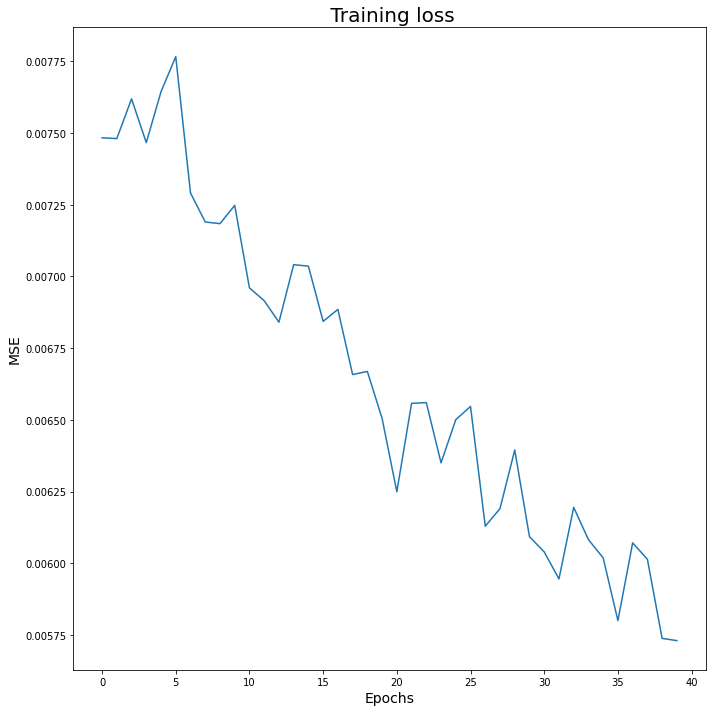

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10))

axes.plot(history.history['loss'])
axes.set_title(' Training loss', fontsize = 20)
axes.set_xlabel('Epochs', fontsize = 14)
axes.set_ylabel('MSE', fontsize = 14)

fig.tight_layout()
plt.show()

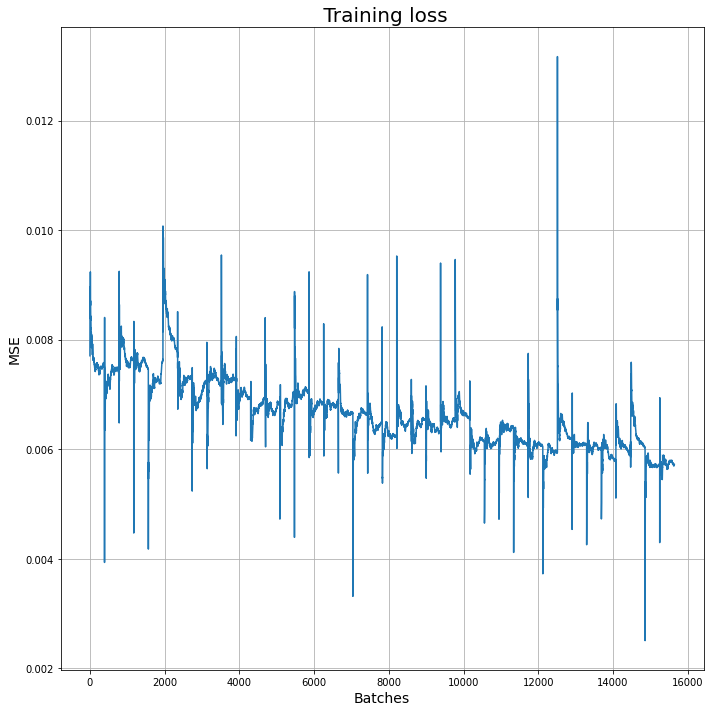

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10))

axes.plot(history_2.loss)
axes.set_title(' Training loss', fontsize = 20)
axes.set_xlabel('Batches', fontsize = 14)
axes.set_ylabel('MSE', fontsize = 14)

fig.tight_layout()
plt.grid()
plt.show()

In [ ]:
batch_size = 16
batch_in, batch_out = next(iter(image_generator(s2_series, batch_size = batch_size, augmentation = False, print_info = False)))
pred = model.predict(batch_in)
pred = np.clip(pred,0.0, 1.0)

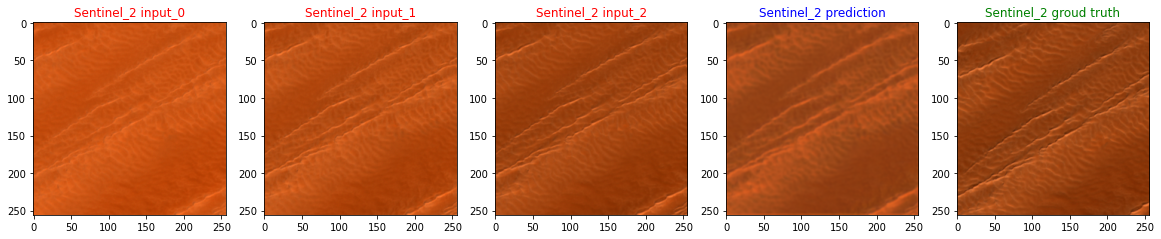

MSE:  0.0040522070514473945
Press any keys to continue...


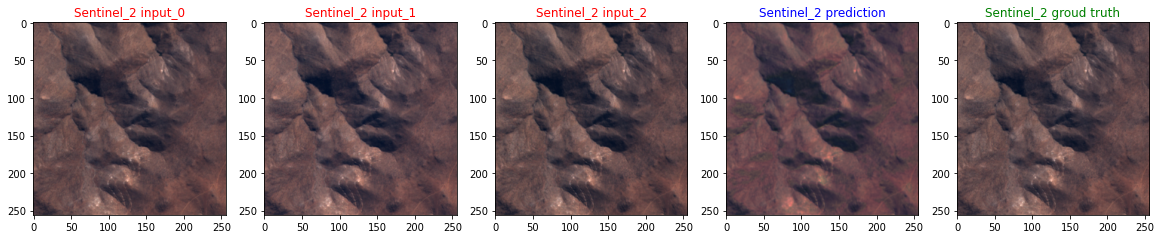

MSE:  0.0005245144116974726
Press any keys to continue...


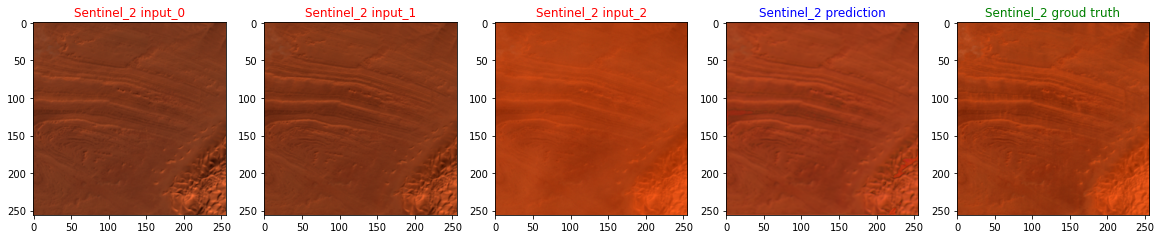

MSE:  0.0010648090518088481
Press any keys to continue...


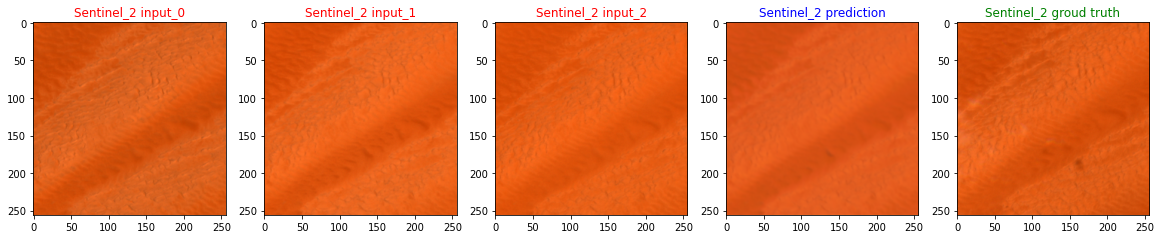

MSE:  0.0010778537596115737
Press any keys to continue...


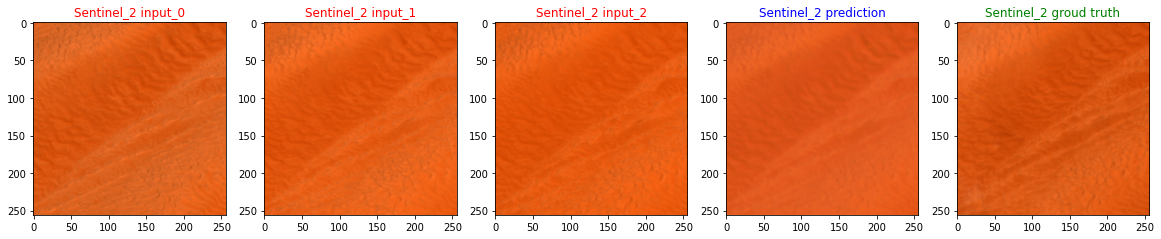

MSE:  0.0014131441972711513
Press any keys to continue...


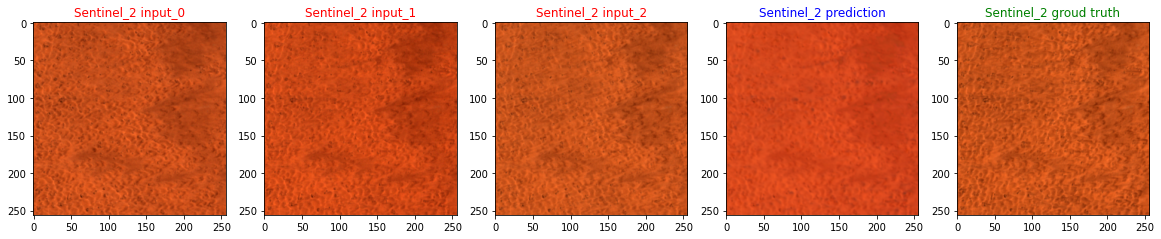

MSE:  0.0025485408754094226
Press any keys to continue...


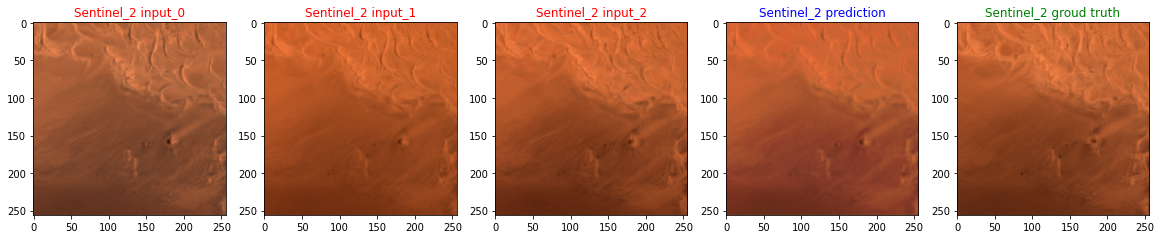

MSE:  0.0014536320558929904
Press any keys to continue...


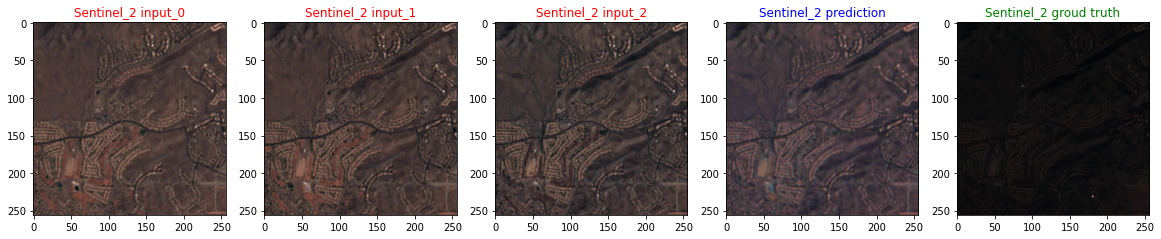

MSE:  0.039100370704665176
Press any keys to continue...


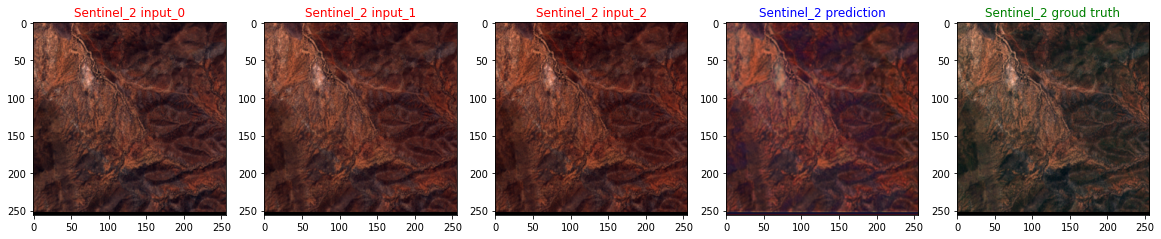

MSE:  0.003419274497961925
Press any keys to continue...


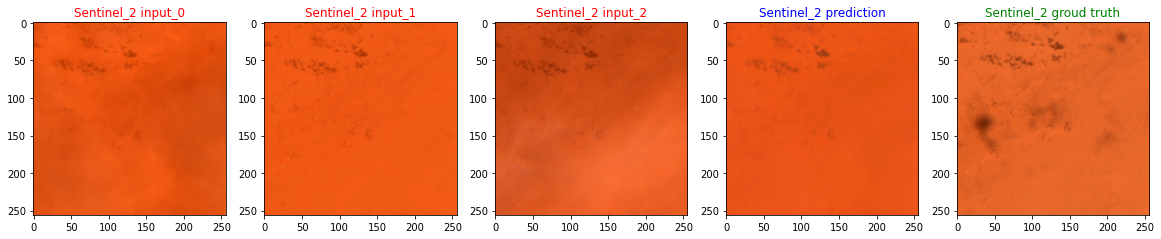

MSE:  0.004205335896402344
Press any keys to continue...


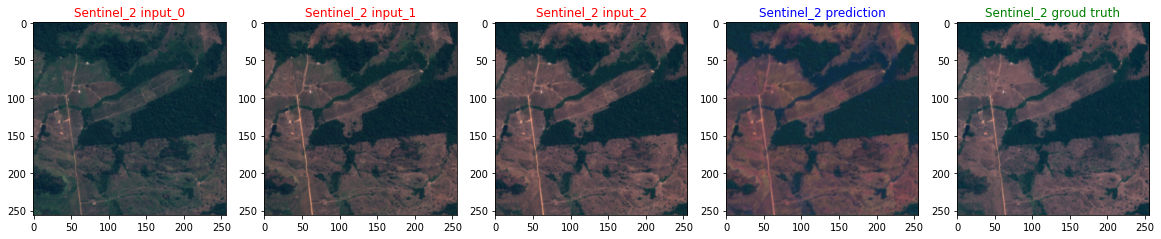

MSE:  0.0014504791127466022
Press any keys to continue...


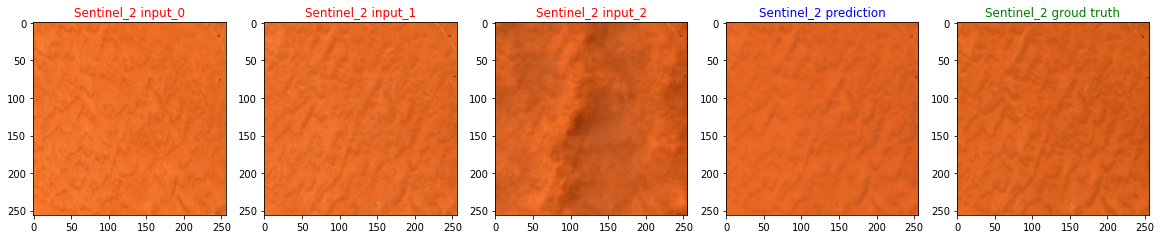

MSE:  0.000715675140640288
Press any keys to continue...


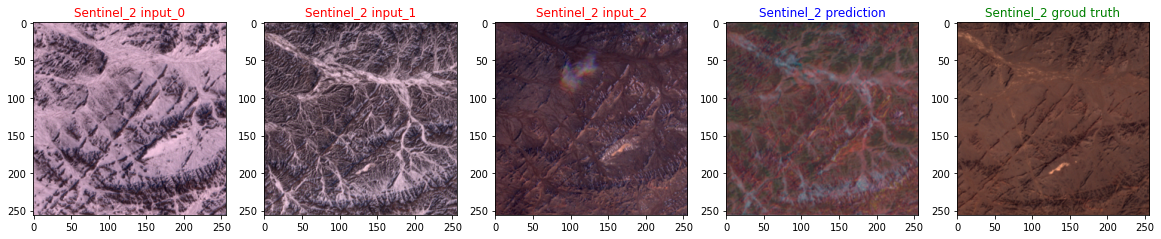

MSE:  0.007097052964572133
Press any keys to continue...


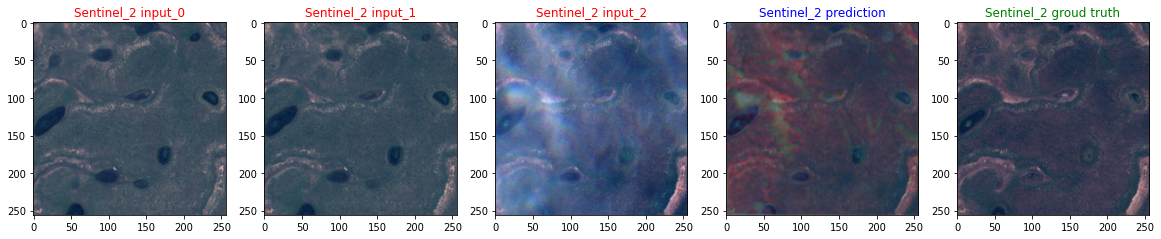

MSE:  0.003135629373869736
Press any keys to continue...


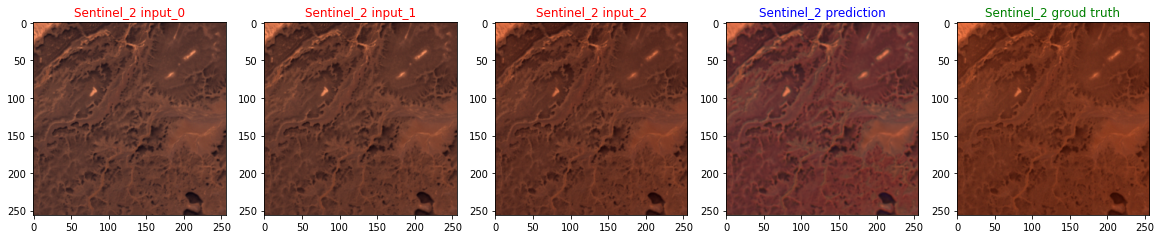

MSE:  0.002894646557734684
Press any keys to continue...


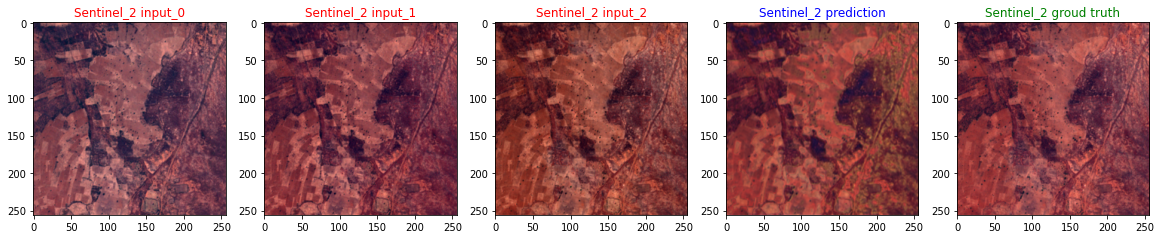

MSE:  0.0033075205510691118
Press any keys to continue...


In [ ]:
counter = 0
for j in range(batch_size):
  fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize=(20,10))

  for i in range(0,3):
      axes[i].imshow(batch_in[j,i,...])
      axes[i].set_title('Sentinel_2 input_'+str(i), color = 'r');

  axes[3].imshow(pred[j,0,...])
  axes[3].set_title('Sentinel_2 prediction', color = 'b');
  axes[4].imshow(batch_out[j,0,...])
  axes[4].set_title('Sentinel_2 groud truth', color = 'g');

  #plt.savefig('/content/drive/My Drive/timeseries_dataset/results_1/test_'+str(j)+'_mse_'+str(mse)+'.png')
  plt.show()
  mse = np.square(np.subtract(pred[j,0,...], batch_out[j,0,...])).mean()

  print('MSE: ', mse)

  input('Press any keys to continue...')
  
  
  plt.close()

# Baseline solution

We want to generate the 4th image using a interpolation strategy. Let assume:
- p_1_r_0_0 the pixel (0,0) of the first image, channel red
- p_2_r_0_0 the pixel (0,0) of the second image, channel red
- p_3_r_0_0 the pixel (0,0) of the thierd image, channel red

Then p_4_r_0_0 can be calculated by a linear or a quadratic interpolation of the previous three points.

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/timeseries_dataset/model_03-06-20_3-layers.h5')

In [ ]:
def interpolate_pixels(p1, p2, p3, interpolation_type = 'linear'):
  x = np.array([0,1,2])
  y = np.array([p1, p2, p3])
  xp = np.linspace(0,3,100)
  
  if interpolation_type == 'linear':
    p = np.polyfit(x,y,1)
  elif interpolation_type == 'quadratic':
    p = np.polyfit(x,y,2)
  elif interpolation_type == 'cubic':
    p = np.polyfit(x,y,3)
      
  interpolation = np.polyval(p, xp)
  predicted_pixel = interpolation[len(interpolation)-1]
  
  return predicted_pixel

def predict_image(image_1, image_2, image_3, interpolation_type = 'linear'):
  predicted_image = np.zeros((256,256,3))
  for i in range(256):
    for j in range(256):
      try:
        predicted_image[i,j,0] = interpolate_pixels(image_1[i,j,0], image_2[i,j,0], image_3[i,j,0], interpolation_type)
        predicted_image[i,j,1] = interpolate_pixels(image_1[i,j,1], image_2[i,j,1], image_3[i,j,1], interpolation_type)
        predicted_image[i,j,2] = interpolate_pixels(image_1[i,j,2], image_2[i,j,2], image_3[i,j,2], interpolation_type)
      except Excpetion:
        print('Missing value')
        pass
            
  return predicted_image

In [ ]:
from skimage import measure
from scipy import signal

def cw_ssim_value(img_a, img_b, width=30):
  """Compute the complex wavelet SSIM (CW-SSIM) value from the reference
  image to the target image.
  Args:
    target (str or PIL.Image): Input image to compare the reference image
    to. This may be a PIL Image object or, to save time, an SSIMImage
    object (e.g. the img member of another SSIM object).
    width: width for the wavelet convolution (default: 30)
  Returns:
    Computed CW-SSIM float value.
  """

  k = 0.01

  # Define a width for the wavelet convolution
  widths = np.arange(1, width+1)

  # Use the image data as arrays
  sig1 = np.asarray(img_a.flatten())
  sig2 = np.asarray(img_b.flatten())

  # Convolution
  cwtmatr1 = signal.cwt(sig1, signal.ricker, widths)
  cwtmatr2 = signal.cwt(sig2, signal.ricker, widths)

  # Compute the first term
  c1c2 = np.multiply(abs(cwtmatr1), abs(cwtmatr2))
  c1_2 = np.square(abs(cwtmatr1))
  c2_2 = np.square(abs(cwtmatr2))
  num_ssim_1 = 2 * np.sum(c1c2, axis=0) + k
  den_ssim_1 = np.sum(c1_2, axis=0) + np.sum(c2_2, axis=0) + k

  # Compute the second term
  c1c2_conj = np.multiply(cwtmatr1, np.conjugate(cwtmatr2))
  num_ssim_2 = 2 * np.abs(np.sum(c1c2_conj, axis=0)) + k
  den_ssim_2 = 2 * np.sum(np.abs(c1c2_conj), axis=0) + k

  # Construct the result
  ssim_map = (num_ssim_1 / den_ssim_1) * (num_ssim_2 / den_ssim_2)

  # Average the per pixel results
  index = np.average(ssim_map)
  return index

In [ ]:
batch_size = 16
batch_in, batch_out = next(iter(image_generator(s2_series, batch_size = batch_size, augmentation = False, print_info = False)))
pred = model.predict(batch_in)
pred = np.clip(pred,0.0, 1.0)

for j in range(batch_size):
  fig, axes = plt.subplots(nrows = 1, ncols = 7, figsize=(30,15))
  interpolation = predict_image(batch_in[j,0,...], batch_in[j,1,...], batch_in[j,2,...])

  mean = (batch_in[j,0,...]+batch_in[j,1,...]+batch_in[j,2,...])/3

  axes[0].imshow(batch_in[j,0,...])
  axes[0].set_title('Sentinel_2 input_'+str(0));
  axes[0].set_yticklabels([])
  axes[0].set_xticklabels([])

  axes[1].imshow(batch_in[j,1,...])
  axes[1].set_title('Sentinel_2 input_'+str(1));
  axes[1].set_yticklabels([])
  axes[1].set_xticklabels([])

  axes[2].imshow(batch_in[j,2,...])
  axes[2].set_title('Sentinel_2 input_'+str(2));
  axes[2].set_yticklabels([])
  axes[2].set_xticklabels([])

  axes[3].imshow(pred[j,0,...])
  axes[3].set_title('Sentinel_2 model prediction');
  axes[3].set_yticklabels([])
  axes[3].set_xticklabels([])

  axes[4].imshow(interpolation)
  axes[4].set_title('Sentinel_2 interpolation');
  axes[4].set_yticklabels([])
  axes[4].set_xticklabels([])

  axes[5].imshow(mean)
  axes[5].set_title('Sentinel_2 mean');
  axes[5].set_yticklabels([])
  axes[5].set_xticklabels([])

  axes[6].imshow(batch_out[j,0,...])
  axes[6].set_title('Sentinel_2 groud truth');
  axes[6].set_yticklabels([])
  axes[6].set_xticklabels([])

  print('Model Prediction')
  p = measure.compare_psnr(batch_out[j,0,...], pred[j,0,...])
  s = measure.compare_ssim(batch_out[j,0,...], pred[j,0,...], multichannel=True)
  s2 = cw_ssim_value(batch_out[j,0,...], pred[j,0,...], width=30)
  print(p, s, s2)

  print('Interpolation')
  p = measure.compare_psnr(batch_out[j,0,...], interpolation)
  s = measure.compare_ssim(batch_out[j,0,...], interpolation, multichannel=True)
  s2 = cw_ssim_value(batch_out[j,0,...], interpolation, width=30)
  print(p, s, s2)

  print('Mean')
  p = measure.compare_psnr(batch_out[j,0,...], mean)
  s = measure.compare_ssim(batch_out[j,0,...], mean, multichannel=True)
  s2 = cw_ssim_value(batch_out[j,0,...], mean, width=30)
  print(p, s, s2)

  plt.show()
  input('Waiting...')
  plt.close()

In [ ]:
batch_size = 16
batch_in, batch_out = next(iter(image_generator(s2_series, batch_size = batch_size, augmentation = False, print_info = False)))
pred = model.predict(batch_in)
pred = np.clip(pred,0.0, 1.0)

for j in range(batch_size):
  fig, axes = plt.subplots(nrows = 1, ncols = 7, figsize=(30,15))
  interpolation = predict_image(batch_in[j,0,...], batch_in[j,1,...], batch_in[j,2,...])

  mean = (batch_in[j,0,...]+batch_in[j,1,...]+batch_in[j,2,...])/3

  axes[0].imshow(batch_in[j,0,...])
  axes[0].set_title('Sentinel_2 input_'+str(0));
  axes[0].set_yticklabels([])
  axes[0].set_xticklabels([])

  axes[1].imshow(batch_in[j,1,...])
  axes[1].set_title('Sentinel_2 input_'+str(1));
  axes[1].set_yticklabels([])
  axes[1].set_xticklabels([])

  axes[2].imshow(batch_in[j,2,...])
  axes[2].set_title('Sentinel_2 input_'+str(2));
  axes[2].set_yticklabels([])
  axes[2].set_xticklabels([])

  axes[3].imshow(pred[j,0,...])
  axes[3].set_title('Sentinel_2 model prediction');
  axes[3].set_yticklabels([])
  axes[3].set_xticklabels([])

  axes[4].imshow(interpolation)
  axes[4].set_title('Sentinel_2 interpolation');
  axes[4].set_yticklabels([])
  axes[4].set_xticklabels([])

  axes[5].imshow(mean)
  axes[5].set_title('Sentinel_2 mean');
  axes[5].set_yticklabels([])
  axes[5].set_xticklabels([])

  axes[6].imshow(batch_out[j,0,...])
  axes[6].set_title('Sentinel_2 groud truth');
  axes[6].set_yticklabels([])
  axes[6].set_xticklabels([])

  print('Model Prediction')
  p = measure.compare_psnr(batch_out[j,0,...], pred[j,0,...])
  s = measure.compare_ssim(batch_out[j,0,...], pred[j,0,...], multichannel=True)
  s2 = cw_ssim_value(batch_out[j,0,...], pred[j,0,...], width=30)
  print(p, s, s2)

  print('Interpolation')
  p = measure.compare_psnr(batch_out[j,0,...], interpolation)
  s = measure.compare_ssim(batch_out[j,0,...], interpolation, multichannel=True)
  s2 = cw_ssim_value(batch_out[j,0,...], interpolation, width=30)
  print(p, s, s2)

  print('Mean')
  p = measure.compare_psnr(batch_out[j,0,...], mean)
  s = measure.compare_ssim(batch_out[j,0,...], mean, multichannel=True)
  s2 = cw_ssim_value(batch_out[j,0,...], mean, width=30)
  print(p, s, s2)

  plt.show()
  input('Waiting...')
  plt.close()

# Combiner model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
gan = load_model('/content/drive/My Drive/timeseries_dataset/GAN_024000.h5')
lstm = load_model('/content/drive/My Drive/timeseries_dataset/LSTM_09-06-20_3-layers.h5')

In [ ]:
def weighted_mean(imgA, imgB, weightA = 1, weightB = 1):
  imgA = np.clip(imgA, 0.0, 1.0)
  imgB = np.clip(imgB, 0.0, 1.0)

  out = imgA*weightA + imgB*weightB / 2.0

  return np.clip(out, 0.0, 1.0)

In [ ]:
'''
def image_generator(s2_paths, s1_paths, batch_size = 16, normalization='minmax'):
    
    batch_s2_input  = np.zeros((3,256,256, 3))
    batch_s1_input  = np.zeros((4, 256,256, 1))
    
    s2out  = np.zeros((batch_size, 256,256, 3))
    s2in  = np.zeros((batch_size,256,256, 6))

    s1 = np.zeros((256,256))
    
    while True:   
           
      for i in range(0, int(batch_size)): 
          
        batch_index = randint(0, high=int(len(s2_paths)/4))*4
        
        for j in range(4):
            
          s2 = get_s2_image(s2_paths[batch_index+j],normalization)
          s1 = get_s1_image(s1_paths[batch_index+j],normalization)
          s1 = s1.reshape(s1.shape[0], s1.shape[1], 1)
          
          # Some images may be smaller than 256x256 pixels, 
          # so the following code forces copying

          if j == 3:
            s2out[i, :s2.shape[0],:s2.shape[1],...] = s2
            batch_s1_input[j, :s1.shape[0],:s1.shape[1],...] = s1
          else:
            batch_s2_input[j,:s2.shape[0],:s2.shape[1],...] = s2

          
          

        lstm_pred = lstm.predict(batch_s2_input[np.newaxis, ...])
        gan_pred = gan.predict(batch_s1_input)

        for j in range(batch_size):        

          s2in[j,...,:3] = lstm_pred[j,0,...]
          s2in[j,...,3:6] = (np.array(gan_pred[j]) + 1) / 2.0
        

        #s2in[i,...,:3] = lstm_pred[0,0,...]
        #s2in[i,...,3:6] = (gan_pred[3,...]+1)/2
      
      yield s2in, s2out

      '''

In [ ]:
def image_generator(s2_paths, s1_paths, batch_size):

    s1out = np.zeros((batch_size, 256, 256, 1))

    batch_s2_input = np.zeros((batch_size, 3, 256, 256, 3))
    s2out = np.zeros((batch_size, 256, 256, 3)) 

    while True:

      for i in range(0, int(batch_size)): 
          
        batch_index = randint(0, high=int(len(s2_paths)/4))*4
        #print(batch_index)
        
        for j in range(4):
            
          s1 = get_s1_image(s1_paths[batch_index+j])
          s1 = s1.reshape(s1.shape[0], s1.shape[1], 1)
          s2 = get_s2_image(s2_paths[batch_index+j])

          if j == 3:
            s1out[i, :s1.shape[0],:s1.shape[1],...] = s1 
            s2out[i, :s2.shape[0],:s2.shape[1],...] = s2          
          else: 
            batch_s2_input[i, j,:s2.shape[0],:s2.shape[1],...] = s2 

      lstm_pred = lstm.predict(batch_s2_input)
      lstm_pred = np.clip(lstm_pred, 0.0, 1.0)

      gan_pred = gan.predict(s1out)
      gan_pred = (np.array(gan_pred) + 1) / 2.0

      s2in  = np.zeros((batch_size,256,256,6))

      for j in range(batch_size):        

        s2in[j,...,:3] = lstm_pred[j,0,...]
        s2in[j,...,3:6] = gan_pred[j]

      yield s2in, s2out

In [ ]:
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization, LeakyReLU, UpSampling2D, Concatenate, Input
from tensorflow.keras.models import Model

In [ ]:
def conv2d(layer_input, filters, f_size=4, bn=True):
    """Layers used during downsampling"""
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if bn:
        d = BatchNormalization(momentum=0.8)(d)
    return d
 
def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    """Layers used during upsampling"""
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
    if dropout_rate:
        u = Dropout(dropout_rate)(u)
    u = BatchNormalization(momentum=0.8)(u)
    u = Concatenate()([u, skip_input])
    return u
 
gf = 32 # number of filters
# Image input
d0 = Input(shape=(256, 256, 6))
 
# Downsampling
d1 = conv2d(d0, gf)
d2 = conv2d(d1, gf*2)
d3 = conv2d(d2, gf*4)
d4 = conv2d(d3, gf*8)
d5 = conv2d(d4, gf*16)
d6 = conv2d(d5, gf*16)
d7 = conv2d(d6, gf*16)
 
# Upsampling
u1 = deconv2d(d7, d6, gf*16)
u2 = deconv2d(u1, d5, gf*16)
u3 = deconv2d(u2, d4, gf*8)
u4 = deconv2d(u3, d3, gf*4)
u5 = deconv2d(u4, d2, gf*2)
u6 = deconv2d(u5, d1, gf)
 
u7 = UpSampling2D(size=2)(u6)
output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='sigmoid')(u7)
 
model = Model(d0, output_img)
#model.summary()
model.compile(optimizer='adam', loss='mse', metrics=['mse', 'mae'])

In [ ]:
batch_size = 16

history = model.fit_generator(
    image_generator(s2_series, s1_series, batch_size = batch_size),
    steps_per_epoch=len(s2_series)//batch_size,
    epochs = 5
) 

In [ ]:
model.save('/content/drive/My Drive/timeseries_dataset/lstm_gan_2_s2.h5')

In [ ]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10,10))

axes[0].plot(history.history['loss'])
axes[0].set_title(' Training loss', fontsize = 20)
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('MSE', fontsize = 14)

axes[1].plot(history.history['mae'])
axes[1].set_title(' Training metrics', fontsize = 20)
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('MAE', fontsize = 14)

fig.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/timeseries_dataset/lstm_gan_2_s2.h5')

In [ ]:
batch_size = 4
b_in, b_out = next(iter(image_generator(s2_series, s1_series, batch_size = batch_size)))
b_pred = model.predict(b_in)

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
for i in range(batch_size):

  p = measure.compare_psnr(b_out[i,...], b_in[i,...,:3])
  s = measure.compare_ssim(b_out[i,...], b_in[i,...,:3], multichannel=True)
  print('Ground truth VS LSTM')
  print(p, s)

  p = measure.compare_psnr(b_out[i,...], b_in[i,...,3:6])
  s = measure.compare_ssim(b_out[i,...], b_in[i,...,3:6], multichannel=True)
  print('Ground truth VS GAN')
  print(p, s)

  p = measure.compare_psnr(b_out[i,...], b_pred[i,...])
  s = measure.compare_ssim(b_out[i,...], b_pred[i,...], multichannel=True)
  print('Ground truth VS Combined')
  print(p, s, s)

  fig, axes = plt.subplots(nrows=1, ncols = 4, figsize = (20,20))
  axes[0].imshow(b_in[i,...,:3])
  axes[0].set_title('LSTM Prediction', fontsize = 20)
  axes[0].set_yticklabels([])
  axes[0].set_xticklabels([])
  axes[1].imshow(b_in[i,...,3:6])
  axes[1].set_title('GAN Prediction', fontsize = 20)
  axes[1].set_yticklabels([])
  axes[1].set_xticklabels([])
  axes[2].imshow(b_out[i,...])
  axes[2].set_title('Ground truth', fontsize = 20)
  axes[2].set_yticklabels([])
  axes[2].set_xticklabels([])
  axes[3].imshow(b_pred[i,...])
  axes[3].set_title('Combined Model prediction', fontsize = 20)
  axes[3].set_yticklabels([])
  axes[3].set_xticklabels([])

  plt.show()

# Test on testing dataset

In [ ]:
dataset_path = '/content/drive/My Drive/timeseries_dataset/timeseries_dataset_p2'
s2_paths, s2_zones = get_images_path(dataset_path, 'sen2')
s1_images, s1_zones = get_images_path(dataset_path, 'sen1')
s2_images, cloud_masks = split_S2_images(s2_paths)
s2_series = get_time_series(s2_images)
s1_series = get_time_series(s1_images)

KeyboardInterrupt: ignored

In [ ]:
batch_size = 4
b_in, b_out = next(iter(image_generator(s2_series, s1_series, batch_size = batch_size)))
b_pred = model.predict(b_in)

In [ ]:
for i in range(batch_size):

  p = measure.compare_psnr(b_out[i,...], b_in[i,...,:3])
  s = measure.compare_ssim(b_out[i,...], b_in[i,...,:3], multichannel=True)
  print('Ground truth VS LSTM')
  print(p, s)

  p = measure.compare_psnr(b_out[i,...], b_in[i,...,3:6])
  s = measure.compare_ssim(b_out[i,...], b_in[i,...,3:6], multichannel=True)
  print('Ground truth VS GAN')
  print(p, s)

  p = measure.compare_psnr(b_out[i,...], b_pred[i,...])
  s = measure.compare_ssim(b_out[i,...], b_pred[i,...], multichannel=True)
  print('Ground truth VS Combined')
  print(p, s, s)

  fig, axes = plt.subplots(nrows=1, ncols = 4, figsize = (20,20))
  axes[0].imshow(b_in[i,...,:3])
  axes[0].set_title('LSTM Prediction', fontsize = 20)
  axes[0].set_yticklabels([])
  axes[0].set_xticklabels([])
  axes[1].imshow(b_in[i,...,3:6])
  axes[1].set_title('GAN Prediction', fontsize = 20)
  axes[1].set_yticklabels([])
  axes[1].set_xticklabels([])
  axes[2].imshow(b_out[i,...])
  axes[2].set_title('Ground truth', fontsize = 20)
  axes[2].set_yticklabels([])
  axes[2].set_xticklabels([])
  axes[3].imshow(b_pred[i,...])
  axes[3].set_title('Combined Model prediction', fontsize = 20)
  axes[3].set_yticklabels([])
  axes[3].set_xticklabels([])

  plt.show()